In [1]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops
from cnn_utils import *
import tensorflow as tf

%matplotlib inline
np.random.seed(1)

d:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Loading the data (signs)
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

y = 5


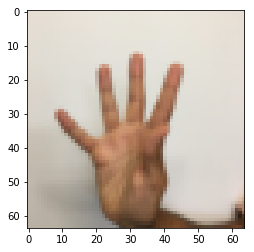

In [3]:
index = 12
plt.imshow(X_train_orig[index])
print ("y = " + str(np.squeeze(Y_train_orig[:, index])))

In [4]:
X_train = X_train_orig/255.
X_test = X_test_orig/255.
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))
conv_layers = {}

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


In [5]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)


def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)


def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')


def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1], padding='SAME')

In [12]:
# coding:utf-8
tf.reset_default_graph()

if __name__ == '__main__':
    # x为训练图像的占位符、y_为训练图像标签的占位符
    x = tf.placeholder(tf.float32, [None, 64, 64, 3])
    y_ = tf.placeholder(tf.float32, [None, 6])

    # 第一层卷积层
    W_conv1 = weight_variable([5, 5, 3, 32])
    b_conv1 = bias_variable([32])
    h_conv1 = tf.nn.relu(conv2d(x, W_conv1) + b_conv1)
    h_pool1 = max_pool_2x2(h_conv1)

    # 第二层卷积层
    W_conv2 = weight_variable([5, 5, 32, 64])
    b_conv2 = bias_variable([64])
    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
    h_pool2 = max_pool_2x2(h_conv2)

    # 全连接层，输出为1024维的向量
    W_fc1 = weight_variable([16 * 16 * 64, 1024])
    b_fc1 = bias_variable([1024])
    h_pool2_flat = tf.reshape(h_pool2, [-1, 16 * 16 * 64])
    h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
    # 使用Dropout，keep_prob是一个占位符，训练时为0.5，测试时为1
    keep_prob = tf.placeholder(tf.float32)
    h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

    # 把1024维的向量转换成10维，对应10个类别
    W_fc2 = weight_variable([1024, 6])
    b_fc2 = bias_variable([6])
    y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

    # 我们不采用先Softmax再计算交叉熵的方法，而是直接用tf.nn.softmax_cross_entropy_with_logits直接计算
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_, logits=y_conv))
    # 同样定义train_step
    train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

    # 定义测试的准确率
    correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
     # 创建Session和变量初始化
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    
    batch=15
    for i in range(31):
        for num in range(72):
            trX = X_train[num*batch:(num+1)*batch-1, :, :, :]
            trY = Y_train[num*batch:(num+1)*batch-1, :]
            train_step.run(feed_dict={x: trX, y_: trY, keep_prob: 0.5})
        if i % 10 == 0:
            train_accuracy = accuracy.eval(feed_dict={x: trX, y_: trY, keep_prob: 1.0})
            print("step %d, training accuracy %g" % (i, train_accuracy))

    print("test accuracy %g" % accuracy.eval(feed_dict={x: X_test, y_: Y_test, keep_prob: 1.0}))

d:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\client\session.py:1645: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


step 0, training accuracy 0.285714
step 10, training accuracy 0.928571
step 20, training accuracy 1
step 30, training accuracy 1
test accuracy 0.941667


d:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  
d:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


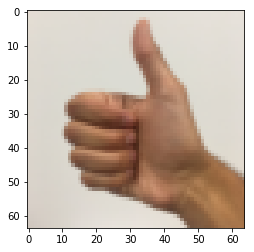

In [7]:
fname = "images/thumbs_up.jpg"
image = np.array(ndimage.imread(fname, flatten=False))
my_image = scipy.misc.imresize(image, size=(64,64))
plt.imshow(my_image)